In [1]:
from pylab import *
%matplotlib inline

In [2]:
caffe_root = '/Users/niekai/caffe'

In [3]:
import sys

In [4]:
sys.path.insert(0, caffe_root + 'python')

In [5]:
import caffe

In [6]:
import os

In [7]:
os.chdir(caffe_root)

In [8]:
!data/mnist/get_mnist.sh

Downloading...


In [9]:
!examples/mnist/create_mnist.sh

Creating lmdb...
I0512 17:45:24.768365 1933950976 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0512 17:45:24.770372 1933950976 convert_mnist_data.cpp:88] A total of 60000 items.
I0512 17:45:24.770401 1933950976 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0512 17:45:25.644948 1933950976 convert_mnist_data.cpp:108] Processed 60000 files.
I0512 17:45:25.701215 1933950976 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0512 17:45:25.712065 1933950976 convert_mnist_data.cpp:88] A total of 10000 items.
I0512 17:45:25.712091 1933950976 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0512 17:45:25.948837 1933950976 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


#### caffe LMDB
- 基于二叉树的数据库管理库，读取效率更高

In [10]:
os.chdir('examples/')

In [11]:
from caffe import layers as L, params as P

In [13]:
batch_size = 64

In [14]:
lmdb = 'mnist/mnist_train_lmdb'

In [15]:
def lenet(lmdb, batch_size):
    n = caffe.NetSpec()

    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb, 
                            transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5,num_output=20,
                          weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()

In [16]:
with open('mnist/test_net_train.prototxt','w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/test_net_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb/', 100)))

In [17]:
!cat mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


In [18]:
!cat mnist/test_net_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

In [18]:
caffe.set_mode_cpu()

In [19]:
solver = None

In [20]:
solver = caffe.SGDSolver('mnist/test_net_solver.prototxt')

In [21]:
[(k, v.data.shape) for k,v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [24]:
[(k, v[0].data.shape) for k,v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [25]:
solver.net.forward()

{'loss': array(2.3605416, dtype=float32)}

In [26]:
solver.test_nets[0].forward()

{'loss': array(2.369924, dtype=float32)}

train labels: [4. 1. 9. 2. 1. 3. 5. 4.]


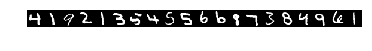

In [44]:
imshow(solver.net.blobs['data'].data[:20,0].transpose(1,0,2).reshape(28, 20*28), cmap='gray');axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

 train labels: [7. 2. 1. 0. 4. 1. 4. 9.]


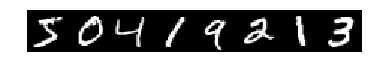

In [32]:
imshow(solver.net.blobs['data'].data[:8,0].transpose(1,0,2).reshape(28, 8*28), cmap='gray');axis('off')
print 'train labels:', solver.test_nets[0].blobs['label'].data[:8]

In [33]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 2min 8s, sys: 4.28 s, total: 2min 12s
Wall time: 2min


Text(0.5,1,u'Test Accuracy: 0.94')

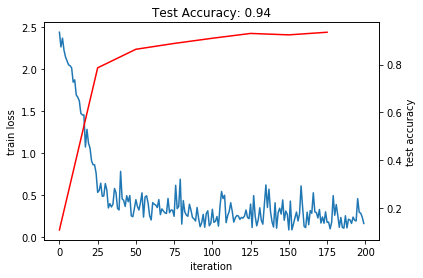

In [34]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

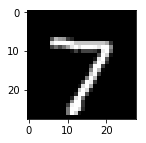

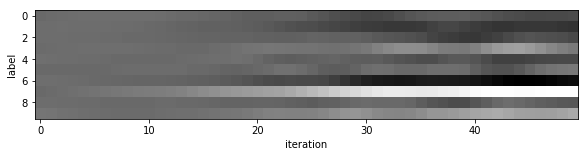

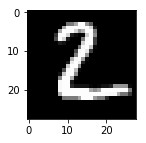

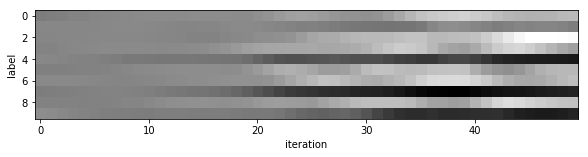

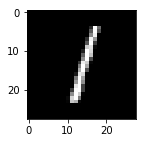

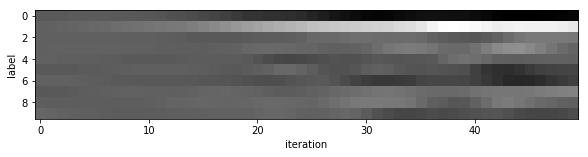

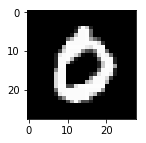

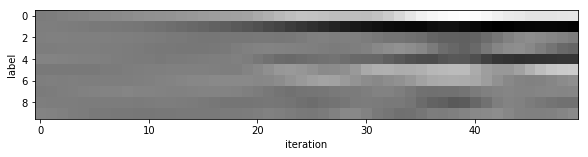

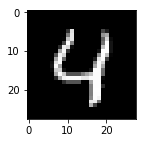

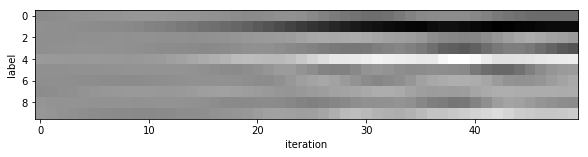

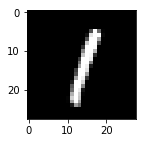

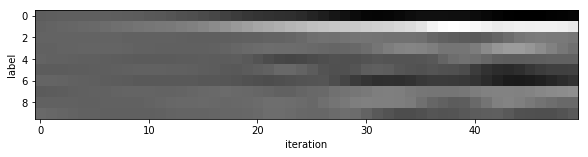

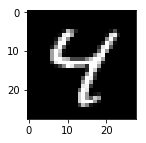

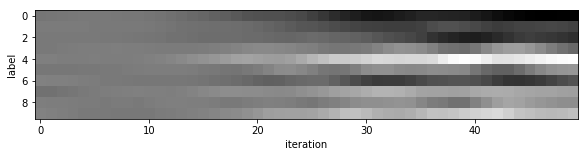

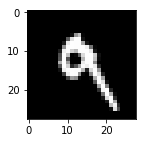

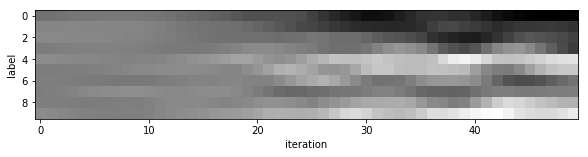

In [35]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

Iteration 0 testing...
Iteration 500 testing...
Iteration 1000 testing...
Iteration 1500 testing...
Iteration 2000 testing...
Iteration 2500 testing...
Iteration 3000 testing...
Iteration 3500 testing...
Iteration 4000 testing...
Iteration 4500 testing...


Text(0.5,1,u'Custom Test Accuracy: 0.98')

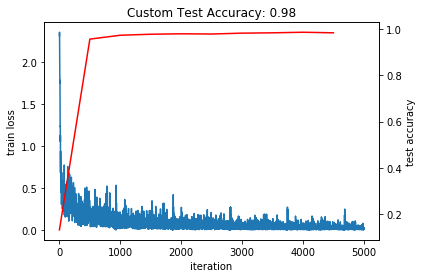

In [40]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

### define net
def custom_net(lmdb, batch_size):
    # define your own net!
    n = caffe.NetSpec()
    
    # keep this data layer for all networks
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    # EDIT HERE to try different networks
    # this single layer defines a simple linear classifier
    # (in particular this defines a multiway logistic regression)
    # n.score =   L.InnerProduct(n.data, num_output=10, weight_filler=dict(type='xavier'))
    
    # EDIT HERE this is the LeNet variant we have already tried
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    # n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool1, num_output=500, weight_filler=dict(type='xavier'))
    # EDIT HERE consider L.ELU or L.Sigmoid for the nonlinearity
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score =   L.InnerProduct(n.fc1, num_output=10, weight_filler=dict(type='xavier'))
    
    # keep this loss layer for all networks
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_train_lmdb', 64)))    
with open(test_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_test_lmdb', 100)))

### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  # Test after every 500 training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.

s.max_iter = 10000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "SGD"

# Set the initial learning rate for SGD.
s.base_lr = 0.01  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 5e-4

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 1000

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)

### solve
niter = 5000  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))